# Q5 PCA

## 5.1 Custom Implementation

### Import necessary libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

### PCA Class

In [24]:
class PCA:
    """
    Custom Implementation of Principal Component Analysis (PCA).

    n_components : int
        Number of principal components to keep.
    """

    def __init__(self, n_components: int):
        """
        Initialize PCA with the desired number of components.

        n_components : int
            The number of dimensions to reduce the data to.
        """
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X: np.ndarray):
        """
        Fit the PCA model to the dataset by computing principal components.

        X : np.ndarray, shape (n_samples, n_features)
            The dataset to fit.

        Returns
        -------
        self : PCA
            Fitted PCA model.
        """
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
 
        # Compute covariance matrix
        cov_matrix = np.cov(X_centered, rowvar=False)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvalues (descending) and corresponding eigenvectors
        sorted_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_idx]
        eigenvectors = eigenvectors[:, sorted_idx]

        # Keep only the top n_components
        self.explained_variance = eigenvalues[:self.n_components]
        self.components = eigenvectors[:, :self.n_components]

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform the dataset into the reduced dimension space.

        X : np.ndarray, shape (n_samples, n_features)
            The dataset to transform.

        Returns
        -------
        X_transformed : np.ndarray, shape (n_samples, n_components)
            Transformed dataset with reduced dimensions.
        """
        if self.mean is None or self.components is None:
            raise RuntimeError("PCA model has not been fitted yet. Call fit() before transform().")

        X_centered = X - self.mean
        X_transformed = np.dot(X_centered, self.components)

        return X_transformed

    def checkPCA(self, X: np.ndarray):
        """
        Check if PCA reduces the dataset to the required dimensions.

        X : np.ndarray, shape (n_samples, n_features)
            Dataset to check PCA on.

        Returns
        -------
        result : bool
            True if PCA reduces dimensions correctly, False otherwise.
        """
        transformed = self.transform(X)
        if(transformed.shape[1] == self.n_components):
            print("PCA dimensionality reduction successful.")
        else :
            print("PCA dimensionality reduction failed.")

## 5.2 PCA on MNIST

Subset shape: (1000, 784)
PCA dimensionality reduction successful.
PCA dimensionality reduction successful.
PCA dimensionality reduction successful.
PCA dimensionality reduction successful.


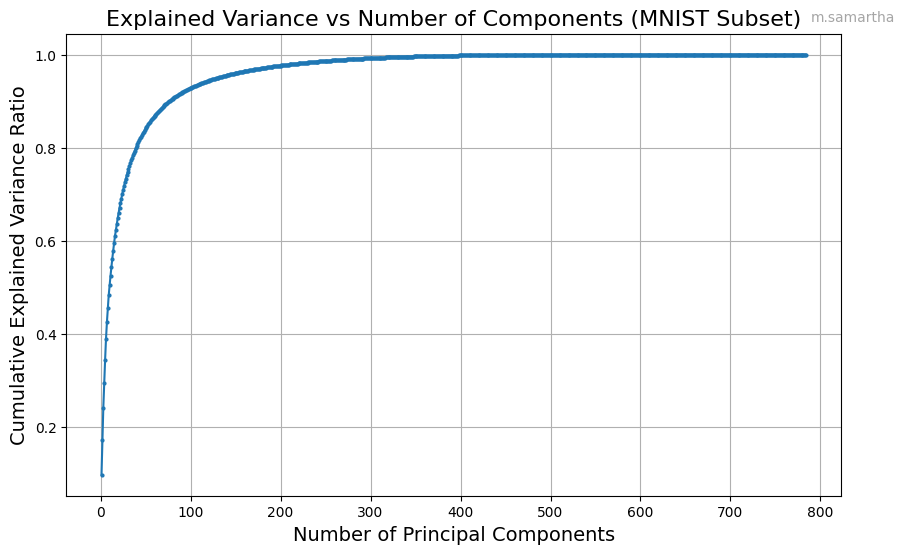

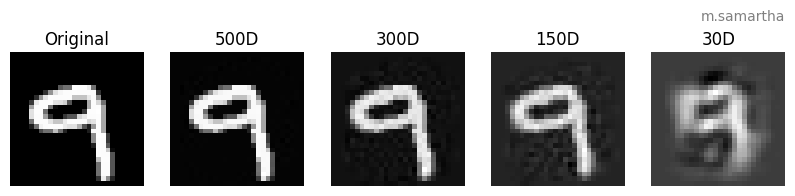

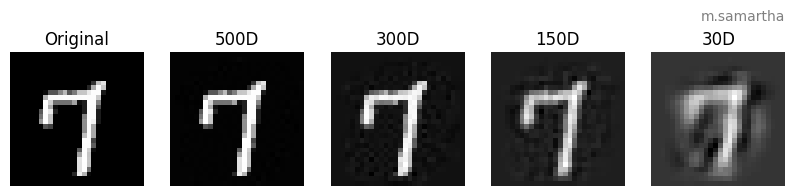

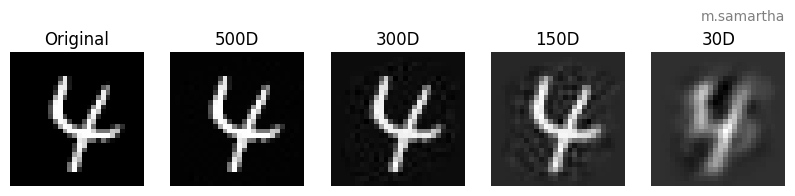

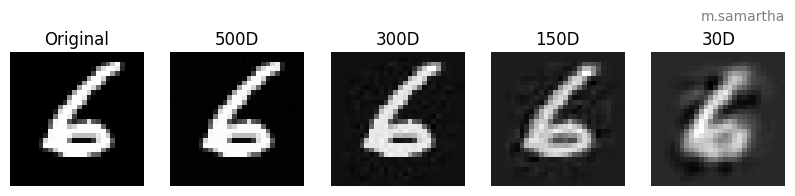

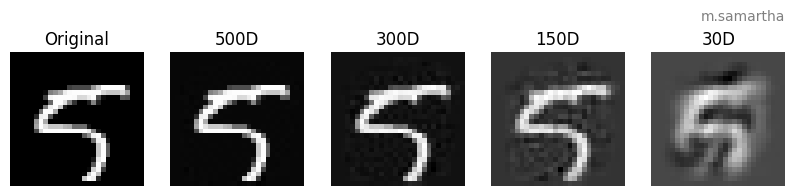

In [25]:
# Load MNIST dataset
mnist = fetch_openml("mnist_784", version=1, as_frame=False, parser="auto")
X, y = mnist.data.astype(np.float32), mnist.target.astype(int)

# Create balanced subset of 1000 samples (100 per digit 0-9)
balanced_idx = []
for digit in range(10):
    digit_idx = np.where(y == digit)[0][:100]
    balanced_idx.extend(digit_idx)

X_subset = X[balanced_idx]
y_subset = y[balanced_idx]
X_original = X_subset.copy()

print("Subset shape:", X_subset.shape)  # (1000, 784)

# Run PCA with custom class implementation
target_dims = [500, 300, 150, 30]
results = {}

for d in target_dims:
    pca = PCA(n_components=d)
    pca.fit(X_subset)
    pca.checkPCA(X_subset)
    X_reduced = pca.transform(X_subset)
    # Reconstruct original images
    X_reconstructed = X_reduced @ pca.components.T + pca.mean
    results[d] = X_reconstructed

# Plot explained variance vs number of components
pca_full = PCA(n_components=784)
pca_full.fit(X_subset)
explained_variance_ratio = np.cumsum(pca_full.explained_variance) / np.sum(pca_full.explained_variance)

plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 785), explained_variance_ratio, marker='o', markersize=2)
plt.xlabel("Number of Principal Components", fontsize=14)
plt.ylabel("Cumulative Explained Variance Ratio", fontsize=14)
plt.title("Explained Variance vs Number of Components (MNIST Subset)", fontsize=16)
plt.grid(True)
plt.text(
    1.07, 1.05, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

# Plot original vs reconstructed images
def plot_reconstruction(idx):
    plt.figure(figsize=(10,4))
    plt.subplot(1, len(target_dims)+1, 1)
    plt.imshow(X_original[idx].reshape(28,28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    for i, d in enumerate(target_dims):
        X_reconstructed = results[d]
        plt.subplot(1, len(target_dims)+1, i+2)
        plt.imshow(X_reconstructed[idx].reshape(28,28), cmap='gray')
        plt.title(f"{d}D")
        plt.axis("off")
    plt.gcf().text(
        0.9, 0.77, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor='none')
    )
    plt.show()

# Plot reconstructions for 5 random images
for idx in np.random.choice(len(X_subset), 5, replace=False):
    plot_reconstruction(idx)

### Observations from the plots
From the expected variance plot, we can observe that the first few principal components capture a significant portion of the variance in the data. This indicates that the data has a lower intrinsic dimensionality than the original feature space. The cumulative variance plot shows that by retaining around 75 principal components, we can capture over 90% of the total variance, suggesting that we can effectively reduce the dimensionality of the dataset while preserving most of its information.

From the reconstructed images, we can see that as we increase the number of principal components used for reconstruction, the quality of the reconstructed images improves. With a small number of components (30), the images appear blurry and lack detail. However, as we increase the number of components to 150 and then to 300, the images become clearer and more recognizable. This demonstrates the effectiveness of PCA in capturing the essential features of the data while reducing its dimensionality.